In [1]:
import numpy as np
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential

In [2]:
df = pd.read_csv('../codes.csv')

In [3]:
#parse a colomn with a 2d array of each qr code
df['code_array'] = df['code'].apply(lambda x: np.array([int(digit) for digit in x]).reshape(29, 29))

In [4]:
#function to initialize model for a given L size input with convo layer

def init_model_convo(L):
    L = (((L*2)+1)**2)*2
    
    # Initialize the Sequential model
    model = tf.keras.Sequential()
    
    # Input layer: Accepts (L, L, 2) where L < 29
    model.add(tf.keras.layers.InputLayer(input_shape=(None, None, 2)))  # None allows for variable L
    
    # Convolutional Layer
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
    
    # Resizing Layer to upscale to 29x29
    model.add(tf.keras.layers.Resizing(height=29, width=29, interpolation='bilinear'))
    
    # Output Layer
    model.add(tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same'))
    
    # Display the model summary
    model.summary()

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    # Compile the model
    model.compile(optimizer=optimizer, loss='mse')

    return model

In [5]:
# Function to split DFT into real and imaginary parts and reshape them
def split_dft(dft_str):
    complex_numbers = [complex(c.strip()) for c in dft_str.strip('()').split(')(')]
    real_part = np.array([c.real for c in complex_numbers])
    imag_part = np.array([c.imag for c in complex_numbers])
    return real_part, imag_part

# Apply the function to each row
df['dft_real'], df['dft_imag'] = zip(*df['dft'].apply(split_dft))

In [6]:
#take in full size 1d array,reshape it to original 29 by 29, and shift it so center is in right place
df['dft_imag_rolled'] = df['dft_imag'].apply(lambda x: np.roll(x.reshape(29,29), shift=(14, 14), axis=(0, 1)))
df['dft_real_rolled'] = df['dft_real'].apply(lambda x: np.roll(x.reshape(29,29), shift=(14, 14), axis=(0, 1)))

In [7]:
y = np.stack(df['code_array'].values)  # Shape: (num_samples, 29,29)

In [8]:
#function to take in array and get L matrix

def get_centered_subarray(array, L):
    L = (L * 2) + 1
    n = array.shape[0]
    center = n // 2
    start = center - (L // 2)
    end = center + (L + 1) // 2
    # Adjust indices to stay within array bounds
    start = max(0, start)
    end = min(n, end)
    return array[start:end, start:end]

In [9]:
# Define a function to combine real and imaginary parts
def combine_real_imag(row):
    # Stack along the last axis to create a new dimension for channels
    combined = np.stack((row['L_real'], row['L_imag']), axis=-1)
    return combined  # Shape: (L, L, 2)

In [10]:
def evaluate_model(model, X, y, num_samples=999):
    #Takes in trained model, input data, correct output data, and number of samples to compute for based on validation set
    #outputs the accuracy of the predicted pixels
    # Ensure num_samples does not exceed the available samples
    num_samples = min(num_samples, X.shape[0])
    
    # Predict the QR codes
    y_pred = model.predict(X[:num_samples])
    
    # Check if the shapes match
    if y_pred.shape != y[:num_samples].shape:
        # If y_pred is (num_samples, 29, 29, 1) and y is (num_samples, 29, 29, 1), it's okay
        # Otherwise, attempt to reshape if possible
        try:
            y_pred = y_pred.reshape(y[:num_samples].shape)
        except:
            raise ValueError(f"Shape mismatch: y_pred shape {y_pred.shape} vs y shape {y[:num_samples].shape}")
    
    # Apply a threshold to convert predictions to binary
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    # Calculate pixel-wise accuracy
    correct_pixels = (y_pred_binary == y[:num_samples]).astype(int)
    pixel_accuracy = correct_pixels.mean()
    
    return pixel_accuracy

In [11]:
#loop to train model for different L sizes. use this loop for convo.

#stat stores L size with accuracy for plotting after
stat = []
for L in [10, 9, 8]:
    #get L matrices flattened
    df['L_imag'] = df['dft_imag_rolled'].apply(lambda x: get_centered_subarray(x, L))
    df['L_real']= df['dft_real_rolled'].apply(lambda x: get_centered_subarray(x, L))

    # Apply the function to each row to create the 'L_combined' column
    df['L'] = df.apply(combine_real_imag, axis=1)
    #diagnostic print
    print(df['L'][0].shape)
    #concatenate imag and real 1d arrays
    model = init_model_convo(L)
    # Features (X) - DFT components
    X = np.stack(df['L'].values)  
    print(X.shape)
    # Split the data into training and testing sets
    #y sets should be initialized outside loop since they don't change
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #Fit the model
    model.fit(X_train, y_train, epochs=50, validation_data=[X_test[1000:], y_test[1000:]])

    #eval model
    accuracy = evaluate_model(model, X_test[:999], y_test[:999], num_samples=1)
    stat.append((L, accuracy))

    print(stat)

(21, 21, 2)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    304       
                                                                 
 resizing (Resizing)         (None, 29, 29, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 1)         145       
                                                                 
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
(9999, 21, 21, 2)
Epoch 1/50
250/250 [==============================] - 6s 21ms/step - loss: 0.3340 - val_loss: 0.3058
Epoch 2/50
250/250 [==============================] - 5s 21ms/step - loss: 0.2926 - val_loss: 0.2829
Epoch 3/50
250/250 [==============================] - 4s 17ms/step - loss: 0.2762 - val_lo

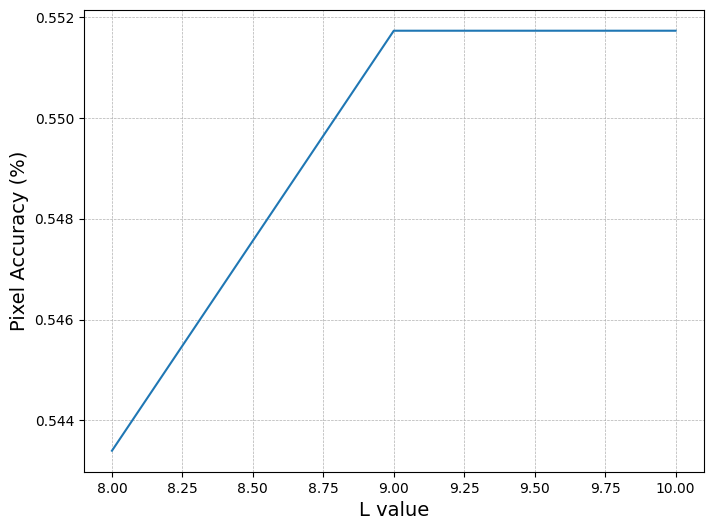

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlabel('L value', fontsize=14)
ax.set_ylabel('Pixel Accuracy (%)', fontsize=14)
ax.plot([st[0] for st in stat], [st[1] for st in stat]) # plots accuracy vs L  

In [16]:
fig.savefig('50_epoch_accuracy.png', dpi=300)

In [15]:
stat

[(10, 0.5517241379310345), (9, 0.5517241379310345), (8, 0.5434007134363853)]